# **Importing libraries**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# **Load Dataset**

In [3]:
file_path = '/content/time_series_covid19_confirmed_global.csv'
data = pd.read_csv(file_path)

In [6]:
print(data.head())


  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0        0        0        0        0  ...   209322  209340  209358  209362   
1        0        0        0        0  ...   334391  334408  334408  334427   
2        0        0        0        0  ...   271441  271448  271463  271469   
3        0        0        0        0  ...    47866   47875   47875   47875   
4        0        0        0        0  ...   105255  105277  105277  105277   

   3/4/23  3/5/23  3/6/23  3/7/23  3/8/23  3/9/23  
0  209369  209390  209406  2

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 1147 entries, Province/State to 3/9/23
dtypes: float64(2), int64(1143), object(2)
memory usage: 2.5+ MB
None


# **Preprocess the data**

In [8]:
data_long = data.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"],
                      var_name="Date", value_name="ConfirmedCases")

In [9]:
data_long['Date'] = pd.to_datetime(data_long['Date'])

<ipython-input-9-12c67c510a60>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_long['Date'] = pd.to_datetime(data_long['Date'])


**Group by Date and aggregate**

In [10]:
data_grouped = data_long.groupby('Date').sum().reset_index()

# **Feature selection**

In [11]:
data_grouped['NewCases'] = data_grouped['ConfirmedCases'].diff().fillna(0)

features = ['ConfirmedCases']
target = 'NewCases'

**Ensure we have no missing values in selected features**

In [12]:
data_grouped = data_grouped.dropna()

# **Split the data into train and test sets**

In [13]:
X = data_grouped[features]
y = data_grouped[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Scale the features**

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Implement Gradient Boosting Regressor**

In [15]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

# **Evaluate the model**

In [16]:
y_pred = gbr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [17]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 121641.30933010908
Mean Squared Error (MSE): 45885193604.54292
R-squared (R²): 0.8836257829563678


# **Optimize the model using GridSearchCV**

In [18]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5]
}
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]})

**Get the best model**

In [19]:
best_model = grid_search.best_estimator_

# **Predict future cases (next 30 days)**

In [20]:
last_date = data_grouped['Date'].max()
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 31)]
future_data = pd.DataFrame(future_dates, columns=['Date'])

**Assuming we predict based on the last known values**

In [21]:

last_known_values = X.iloc[-1].values.reshape(1, -1)
future_predictions = best_model.predict(np.tile(last_known_values, (30, 1)))

# **Visualization**

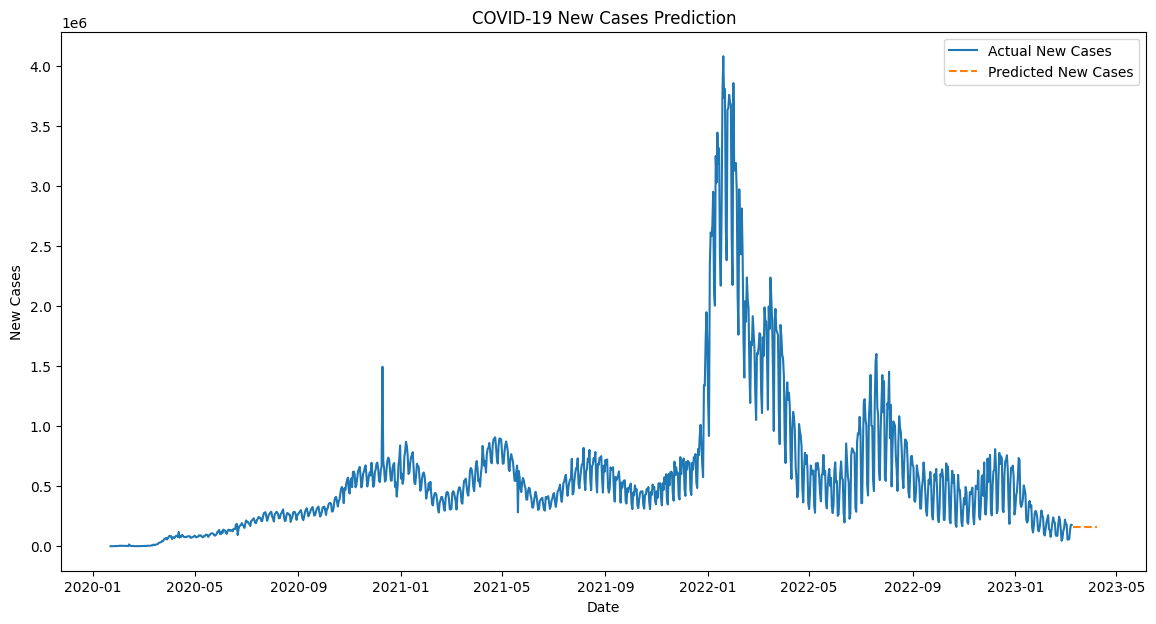

In [22]:

plt.figure(figsize=(14, 7))
plt.plot(data_grouped['Date'], data_grouped['NewCases'], label='Actual New Cases')
plt.plot(future_dates, future_predictions, label='Predicted New Cases', linestyle='--')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.title('COVID-19 New Cases Prediction')
plt.legend()
plt.show()

In [23]:

print("Best model parameters:", grid_search.best_params_)

Best model parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
